# Ejercicio 2

In [1]:
import numpy as np
import networkx as nx
from scipy.optimize import curve_fit
from itertools import chain
from matplotlib import pyplot as plt
%matplotlib notebook

def ldata(archive):
    f=open(archive)
    data=[]
    for line in f:
        line=line.strip()
        col=line.split()
        data.append(col)	
    return data

Cargo el grafo creado a partir de las relaciones entre un grupo de delfines y le asigno a cada uno su sexo:

In [2]:
dolphins = nx.read_gml('TC01_data/dolphins.gml')
gender = ldata('TC01_data/dolphinsGender.txt')
gender = [gender[n][1] for n in range(len(gender))]

for n,g in zip(dolphins.nodes,gender):
    dolphins.nodes[n]["gender"] = g

### Layout de la red
Entre los layouts propuestos (random, circular, spectral, shell, spring), el formato 'spring' permitió observar dos grupos.

<IPython.core.display.Javascript object>


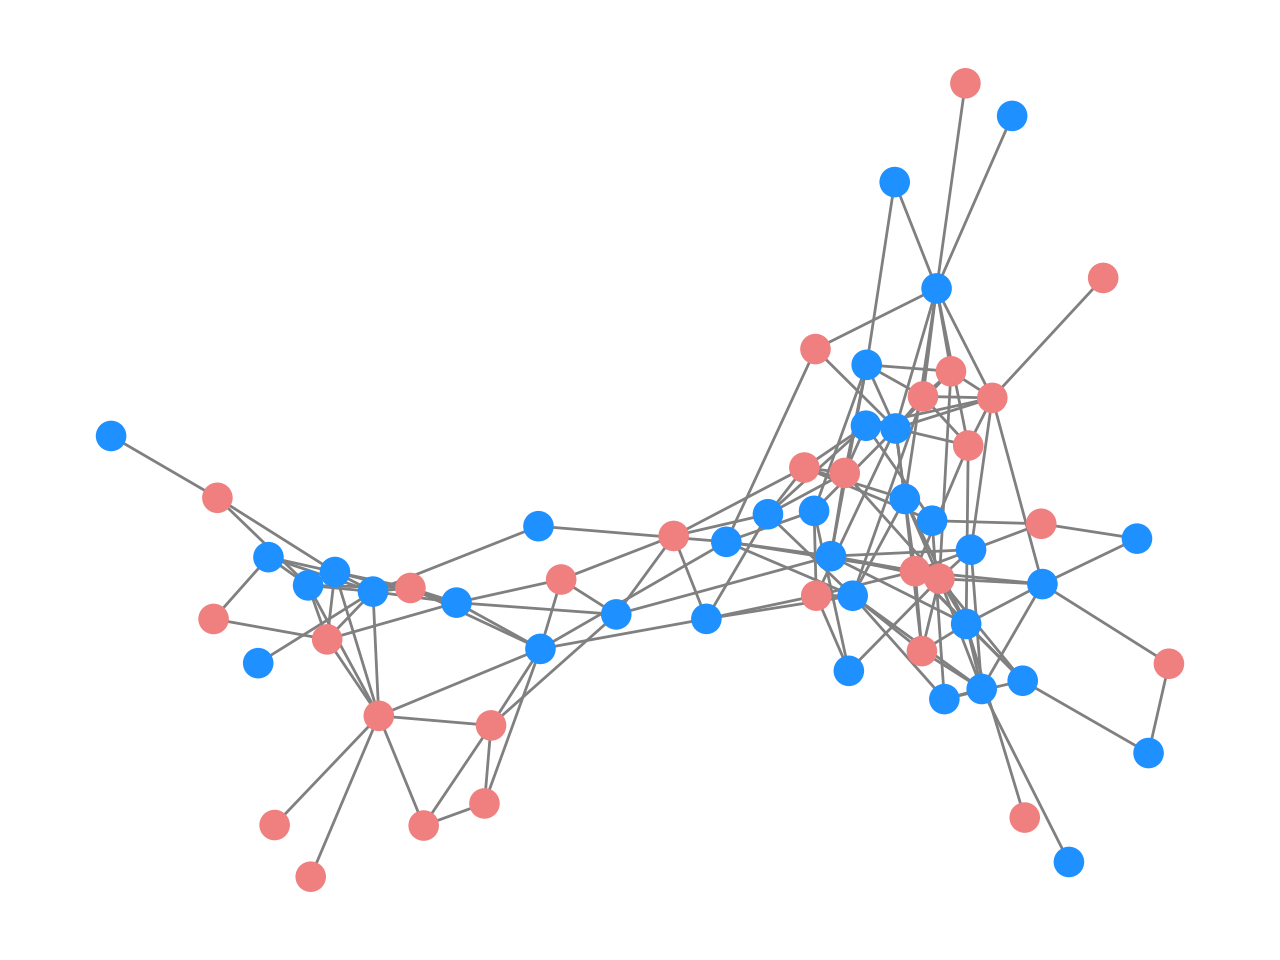

In [4]:
nx.draw(dolphins,
        node_color= ['dodgerblue' if g=="m" else "lightcoral" for g in nx.get_node_attributes(dolphins, "gender").values()] , 
        node_size=100, edge_color='grey')

### Cuantificación de la homofilia

Queremos saber si en las redes sociales formadas por la especie de delfín de los datos hay una tendencia a la homofilia.
Usando la topología de la red previamente graficada, es decir, preservando enlaces, nodos y proporción de género de la red original, generamos la distribución de enlaces heterosexuales a partir de n=10000 asignaciones aleatorias de género a cada nodo. Es decir, nuestra hipótesis nula es que los datos provienen de una red social 

<IPython.core.display.Javascript object>


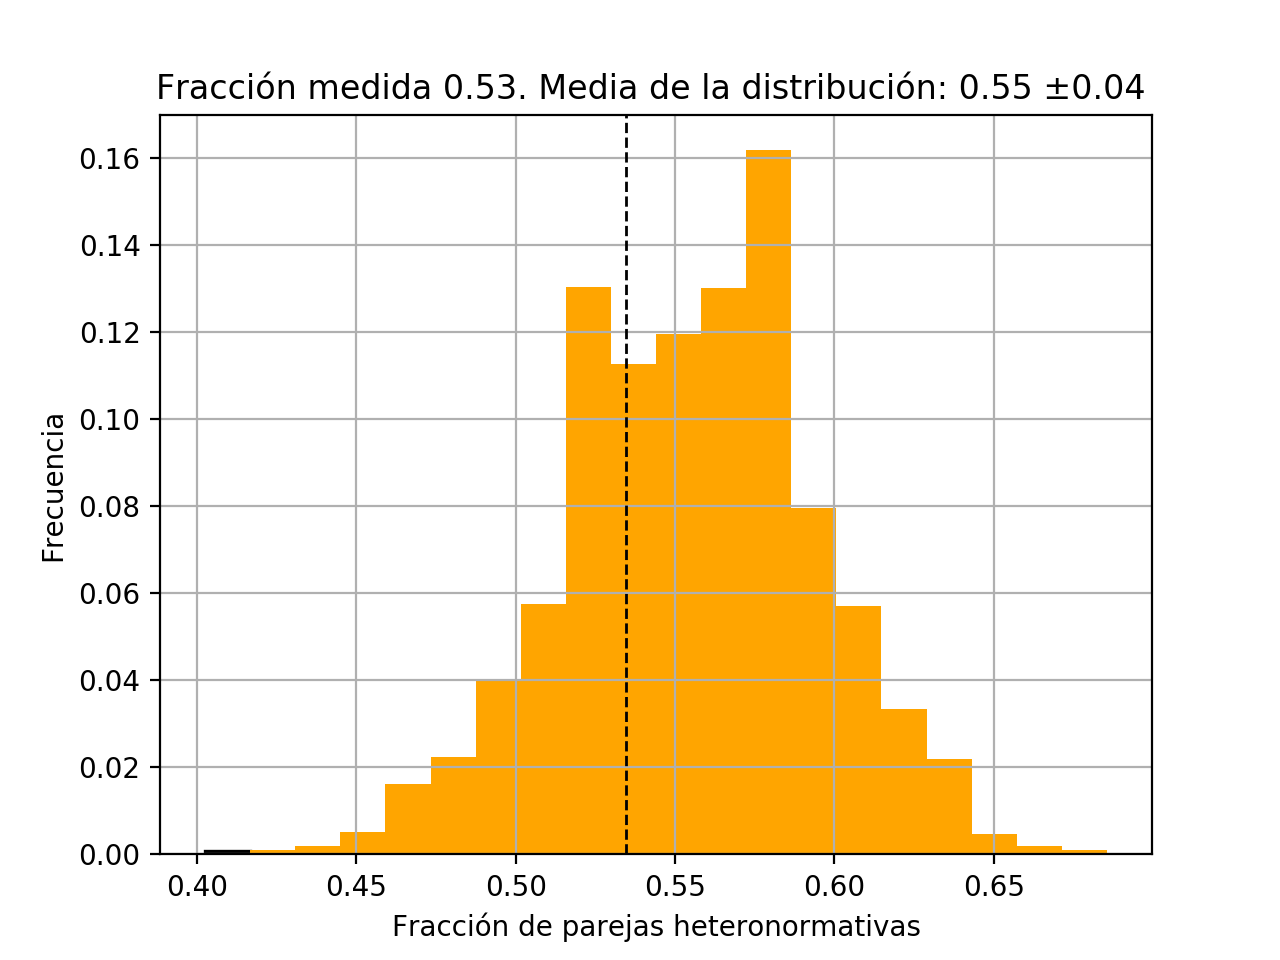

Fracción de parejas heterosexuales medida: 0.53
Media y desviación de la ditribución 0.55 ±0.04


In [12]:
## Devuelve  la fracción que representan las parejas heterosexuales
## respecto al total
def straight(graph):
    edges = list(dict(graph.edges))
    hetero = [ edges[n] if graph.nodes[edges[n][0]] != graph.nodes[edges[n][1]] 
    else '' for n in range(graph.number_of_edges())]
    hetero = list(set(list(hetero)))[1:]
    return len(hetero)
    

##Reasigna un atributo aleatoriamente manteniendo la proporción
## original de dicho atributo
def bend(graph, attribute, name_attribute='gender'):
    np.random.shuffle(attribute)
    for n,g in zip(graph.nodes,attribute):
        graph.nodes[n][name_attribute] = g               
    return graph 

##Genera la distribución mediante un histograma
times = 10000
fraccion = []
fraccion_medida = straight(dolphins)/dolphins.number_of_edges() ##Fracción medida de parejas heterosexuales

for n in range(times):
    dolphins = bend(dolphins, gender, name_attribute='gender')
    fraccion.append(straight(dolphins)/dolphins.number_of_edges())
    
freq, binedges = np.histogram(fraccion, bins=20)
norm = sum(freq)
freq_normed = [i/norm for i in freq]
bincenters = 0.5*(binedges[1:]+binedges[:-1])
lins = {'linestyle': 'None'}

mean = np.mean(fraccion)
stdev = np.std(fraccion)

plt.figure(2)
plt.rc('lines', **lins)
plt.axvline(x=fraccion_medida, color='k', linestyle='dashed', linewidth=1)
plt.bar(bincenters,freq_normed, color='orange',edgecolor='black', linewidth=1.2, width = np.diff(binedges))
plt.grid(True)
plt.ylabel('Frecuencia')
plt.xlabel('Fracción de parejas heteronormativas' )
plt.title('Fracción medida %s. Media de la distribución: %s ±% s ' 
%(round(fraccion_medida,2),round(mean,2 ),round(stdev,2) ))

print('Fracción de parejas heterosexuales medida: %s' %round(fraccion_medida,2))
print('Media y desviación de la ditribución %s ±% s' %(round(mean,2), round(stdev,2)))

Para cuantificar si el valor de enlaces heterosexuales era esperado según la hipótesis propuesta, se calculó el p-value.

In [9]:
def pval(freq,bines,Tobs):
    bineslef = bines[:-1]
    cumprob = [sum(freq[0:i+1]) for i in range(len(freq))]
    i = 1
    if bineslef[0] >= Tobs:
        return 1
    elif bineslef[-1] < Tobs:
        return 1 - cumprob[-1]
    else:
        while bineslef[i] < Tobs:
            if i < len(bineslef)-1:
                i+=1
            else:
                break
        return 1 - cumprob[i-1] 
p_val = pval(freq_normed, binedges, fraccion_medida)
print('p-value del estadístico "Fracción medida": %s' %round(p_val,2))

p-value del estadístico "Fracción medida": 0.89
